Objective:- To find the best model with highest accuracy for Naive Bayes and also find precision, recall ,f1-score and confusion matrix for each madel.

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_selection import chi2

C:\Users\pavan\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\pavan\\Desktop\\Applied AI course\\amazon-food-reviews_dataset\\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [6]:
#Removes duplicate data from dataset that are repeated.

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [7]:
#Sorting data on basis of TIME

final = final.sort_values(by=['Time'], axis=0)
final.shape

(364171, 10)

In [8]:
#Perform text pre-processing

"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation/special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):
                    s=(sno.stem(cleaned_words))
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [9]:
amazon_data_text = pd.Series(final_text)
amazon_data_label = pd.Series(final['Score'])
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(364171,)
(364171,)


In [10]:
#Spliiting sample data into train_data and test_data
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
                                                                     amazon_data_text,\
                                                                     amazon_data_label,\
                                                                     test_size = 0.25,\
                                                                     random_state=0)
                                                                     


In [11]:
print("Train_data: \n", y_train.value_counts())

Train_data: 
 positive    230354
negative     42774
Name: Score, dtype: int64


In [12]:
print("Test_data: \n", y_test.value_counts())

Test_data: 
 positive    76707
negative    14336
Name: Score, dtype: int64


In [32]:
#Converts train_data from text to vectors by BoW
#count_vect = CountVectorizer(analyzer='word') #in scikit-learn
bow_text_train_vector = count_vect.fit_transform(x_train)
bow_text_train_vector = bow_text_train_vector
bow_text_train_vector.shape


(273128, 61712)

In [14]:
#this code shows feautureselection

a = chi2(bow_text_train_vector, y_train)
print("chi2's statistics: ", a[0])
print("feature probabilities: ", a[1])


chi2's statistics:  [0.37137623 2.92261259 0.18568811 ... 0.18568811 0.18568811 0.18568811]
feature probabilities:  [0.54225506 0.08734634 0.66652986 ... 0.66652986 0.66652986 0.66652986]


In [33]:
#Converts test_data from text to vectors by BoW

bow_text_test_vector = count_vect.transform(x_test)
bow_text_test_vector = bow_text_test_vector
print(bow_text_test_vector.shape)


(91043, 61712)


The optimal value of alpha is 324.


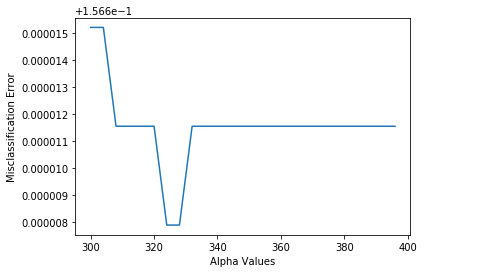

the misclassification error for each alpha value is :  [0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157]


In [27]:
#find lambda for BernoulliNB and plot error
# empty list that will hold cv scores
cv_scores = []
alpha_values = list(range(300,400,4))
# perform 10-fold cross validation
for al in alpha_values:
    nb = BernoulliNB(alpha = al)
    scores = cross_val_score(nb, bow_text_train_vector, 
                             y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best alpha
bow_optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('The optimal value of alpha is %d.' % bow_optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)

for xy in zip(alpha_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))


The accuracy of the Naive Bayes classifier for alpha = 324 is 84.251398%


Text(0.5,1,'Confusion Matrix')

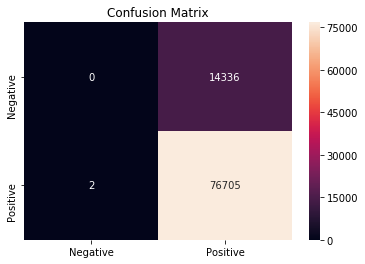

In [34]:
#To apply BernoulliNB for above lambda value
nb = BernoulliNB(alpha = bow_optimal_alpha)
nb.fit(bow_text_train_vector, y_train)
pred = nb.predict(bow_text_test_vector)
acc = accuracy_score(y_test, pred)*100 #Evaluate accuracy
print('\nThe accuracy of the Naive Bayes classifier for alpha = %d is %f%%' % (bow_optimal_alpha, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confusion Matrix")

In [35]:
#To show precision. recall, f1 and support vectors for BernoulliNB

print(classification_report(y_test, pred, target_names = np.unique(y_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00     14336
   positive       0.84      1.00      0.91     76707

avg / total       0.71      0.84      0.77     91043



The optimal value of alpha is 480.


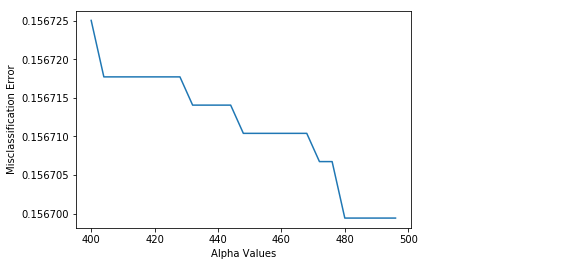

the misclassification error for each alpha value is :  [0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157]


In [36]:
#find lambda for MultinomialNB and plot error
# empty list that will hold cv scores
cv_scores = []
alpha_values = list(range(400,500,4))
# perform 10-fold cross validation
for al in alpha_values:
    nb = MultinomialNB(alpha = al)
    scores = cross_val_score(nb, bow_text_train_vector, 
                             y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best alpha
bow_optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('The optimal value of alpha is %d.' % bow_optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)

for xy in zip(alpha_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))


The accuracy of the Naive Bayes classifier for alpha = 480 is 84.253594%


Text(0.5,1,'Confusion Matrix')

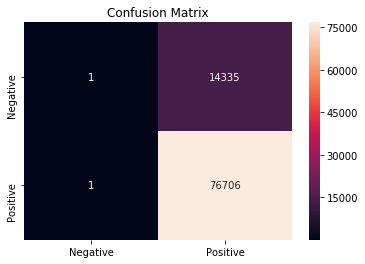

In [37]:
#To apply MultinomialNB for above lambda value
nb = MultinomialNB(alpha = bow_optimal_alpha)
nb.fit(bow_text_train_vector, y_train)
pred = nb.predict(bow_text_test_vector)
acc = accuracy_score(y_test, pred)*100 #Evaluate accuracy
print('\nThe accuracy of the Naive Bayes classifier for alpha = %d is %f%%' % (bow_optimal_alpha, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confusion Matrix")

In [38]:
#To show precision. recall, f1 and support vectors for MultinomialNB

print(classification_report(y_test, pred, target_names = np.unique(y_test)))

             precision    recall  f1-score   support

   negative       0.50      0.00      0.00     14336
   positive       0.84      1.00      0.91     76707

avg / total       0.79      0.84      0.77     91043



Observation :

- Here we have applied Bag of words to convert text to vector.
- We got best hyperparameter for the BernoulliNB model is 324 with accuracy 84.251398% .
- We got best hyperparameter for the MultinomialNB model is 480 with accuracy 84.253594% .


In [39]:
#Converts train_data from text to vectors by TF_IDF
#count_vect = CountVectorizer(analyzer='word') #in scikit-learn
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(x_train)
final_tf_idf_train.shape


(273128, 2436312)

In [40]:
#Converts test_data from text to vectors by TF_IDF
final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_test.shape

(91043, 2436312)

In [41]:
#this code shows feautureselection

a = chi2(final_tf_idf_train, y_train)
print("chi2's statistics: ", a[0])
print("feature probabilities: ", a[1])


chi2's statistics:  [0.03995276 0.03601368 0.00524348 ... 0.02876846 0.04075579 0.04075579]
feature probabilities:  [0.84157297 0.84948724 0.94227415 ... 0.86531476 0.84001003 0.84001003]


The optimal value of alpha is 38.


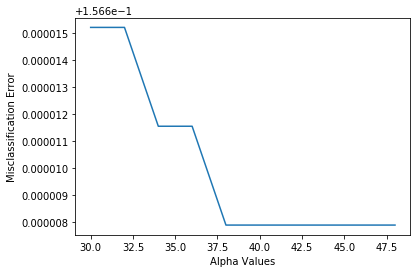

the misclassification error for each alpha value is :  [0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157]


In [44]:
#find lambda for BernoulliNB and plot error
# empty list that will hold cv scores
cv_scores = []
alpha_values = list(range(30,50,2))
# perform 10-fold cross validation
for al in alpha_values:
    nb = BernoulliNB(alpha = al)
    scores = cross_val_score(nb, final_tf_idf_train, 
                             y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('The optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)

for xy in zip(alpha_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))


The accuracy of the Naive Bayes classifier for alpha = 38 is 84.253594%


Text(0.5,1,'Confusion Matrix')

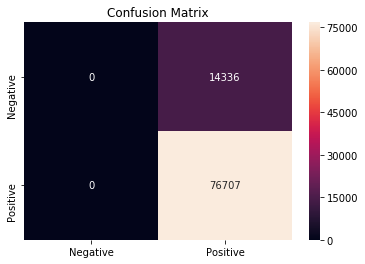

In [46]:
#To apply BernoulliNB for above lambda value
nb = BernoulliNB(alpha = optimal_alpha)
nb.fit(final_tf_idf_train, y_train)
pred = nb.predict(final_tf_idf_test)
acc = accuracy_score(y_test, pred)*100 #Evaluate accuracy
print('\nThe accuracy of the Naive Bayes classifier for alpha = %d is %f%%' % (optimal_alpha, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confusion Matrix")

In [47]:
#To show precision. recall, f1 and support vectors for BernoulliNB

print(classification_report(y_test, pred, target_names = np.unique(y_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00     14336
   positive       0.84      1.00      0.91     76707

avg / total       0.71      0.84      0.77     91043



C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The optimal value of alpha is 5.


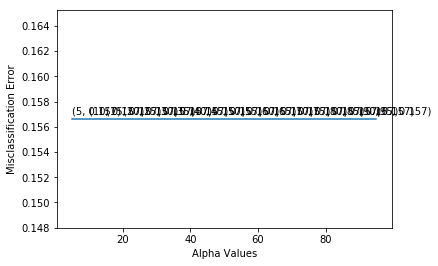

the misclassification error for each alpha value is :  [0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157 0.157
 0.157 0.157 0.157 0.157 0.157 0.157 0.157]


In [54]:
#find lambda for MultinomialNB and plot error
# empty list that will hold cv scores
cv_scores = []
alpha_values = list(range(5,100,5))
# perform 10-fold cross validation
for al in alpha_values:
    nb = MultinomialNB(alpha = al)
    scores = cross_val_score(nb, final_tf_idf_train, 
                             y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('The optimal value of alpha is %d.' % optimal_alpha)

# plot misclassification error vs alpha 
plt.plot(alpha_values, MSE)

for xy in zip(alpha_values, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Alpha Values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))


The accuracy of the Naive Bayes classifier for alpha = 5 is 84.253594%


Text(0.5,1,'Confusion Matrix')

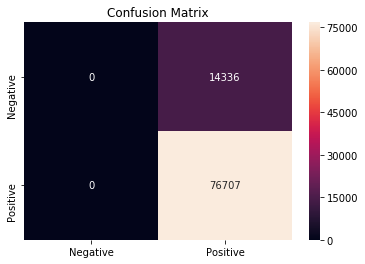

In [55]:
#To apply MultinomialNB for above lambda value
nb = MultinomialNB(alpha = optimal_alpha)
nb.fit(final_tf_idf_train, y_train)
pred = nb.predict(final_tf_idf_test)
acc = accuracy_score(y_test, pred)*100 #Evaluate accuracy
print('\nThe accuracy of the Naive Bayes classifier for alpha = %d is %f%%' % (optimal_alpha, acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("Confusion Matrix")

In [50]:
#To show precision. recall, f1 and support vectors for BernoulliNB

print(classification_report(y_test, pred, target_names = np.unique(y_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00     14336
   positive       0.84      1.00      0.91     76707

avg / total       0.71      0.84      0.77     91043



C:\Users\pavan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Observation :

- Here we have applied TF_IDF to convert text to vector.
- We got best hyperparameter for the BernoulliNB model is 38 with accuracy 84.253594%% .
- We got best hyperparameter for the MultinomialNB model is 5 with accuracy 84.253594% .
- MultinomialNB model for TF_IDF is underfitting 

Conclusion:-

- BernoulliNB deals with binary classifications and MultinomialNB deals with multiclass classifications.
- Through feature selection we can choose the important feature for our model to train on.
- Naive Bayes method is a performance benchmark for all advanced text classification techniques.